# Picture to PETSCII
Let's convert a image into text, using the C64 character set. Individual glyphs will be tested with [Discrete Cosine Transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform) against their overlapping portion of the image.

### Open the source images

RGB


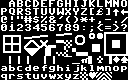

In [7]:
%matplotlib inline

from PIL import Image

glyphs_input = Image.open("c64_petscii.png").convert("RGB")
print(glyphs_input.mode)
glyphs_input

Convert the source image of glyphs into individual glyphs

In [8]:
import matplotlib.pyplot as plt
import PIL.ImageOps    

glyph_x, glyph_y = 8, 8
gsw, gsh = glyphs_input.size
print(gsw/glyph_x, gsh/glyph_y)

glyphs = []
for y in range(0, gsw, glyph_y):
    for x in range(0, gsh, glyph_x):
        glyphs.append(glyphs_input.crop((x, y, x+glyph_x, y+glyph_y)))  

# C64 can also invert BG and FG colors for characters
glyphs.extend([PIL.ImageOps.invert(g) for g in glyphs])

# test that we are reading the glyphs correctly
display(*glyphs[0:5])

16.0 10.0


Load our source image that we will test against

RGB
(480, 320)


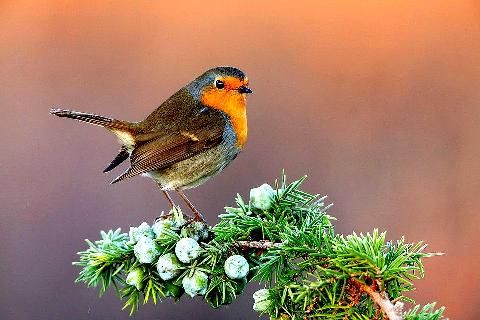

In [9]:
source = Image.open("robin.jpg")
source = source.convert("RGB")

# scale down
rescale_down = 2
source = source.resize((source.width//rescale_down, source.height//rescale_down))

# crop image to multiples of glyph size
source = source.crop((0, 0, (source.width//glyph_x)*glyph_x, (source.height//glyph_y)*glyph_y))

print(source.mode)
print(source.size)
source

### Iterate over image
Test which glyph fits the location best, based on [Least Squares](https://en.wikipedia.org/wiki/Least_squares).

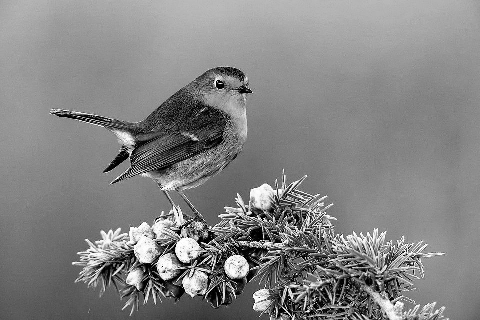

In [10]:
import random
import numpy as np

# convert PIL Image into Numpy array
def image2px(image):
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
    im_arr = im_arr.reshape((image.size[1], image.size[0], 3)) 
    return im_arr

# convert RGB numpy array to grayscale
def array2gs(array):
    return np.dot(array[...,:3], [0.299, 0.587, 0.114])

# converts the image data into numpy arrays so it can be numerically processed
tarr = array2gs(image2px(source)).T
np_glyphs = [array2gs(image2px(g)).T for g in glyphs]

Image.fromarray(np.uint8(tarr.T))

Now that we have initialized out images as grayscale numerical arrays, we can easily manipulate them

All we have to do is loop over the image, using the glyph size as a step. For each location calculate Least Squares for the overlapping image data and the glyph (in grayscale). Then place the glyph that has least error into that location.

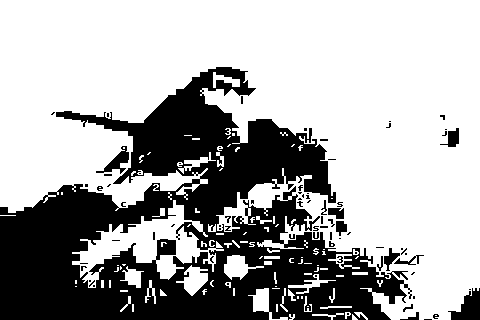

In [11]:
def least_squares(a, b):
    return np.sum((a - b)**2)

def make_best_fit(error_function):
    def _best_fit(iarr, iglyphs, x, y):
        best_fit = -1
        min_error = float(1e10)

        # find glyph with best fit
        for i, g in enumerate(np_glyphs):
            error = error_function(g, iarr[x:x+glyph_x, y:y+glyph_y])
            if error < min_error:
                best_fit = i
                min_error = error
        return best_fit
    return _best_fit
    
def generate(best_fit_function, iarr, igly, pgly):
    output = np.zeros(iarr.shape)
    
    # loop over the target image
    for y in range(0, iarr.shape[1], glyph_y):
        for x in range(0, iarr.shape[0], glyph_x):
            best_fit = best_fit_function(iarr, igly, x, y)

            # render the best glyph to the target image
            if best_fit >= 0:
                output[x:x+glyph_x, y:y+glyph_y] = pgly[best_fit]
                
    return Image.fromarray(np.uint8(output.T))
      
generate(make_best_fit(least_squares), tarr, np_glyphs, np_glyphs)

It's a bit boring. Maybe add some randomness to spice things up?

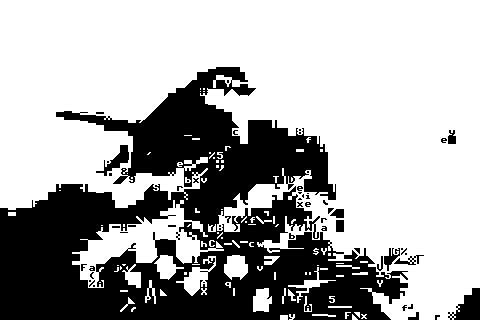

In [12]:
def build_error_function(v):
    def _lsr(a, b):
        return np.sum((a - b)**2)*((1.0-v) + random.random()*v)
    return _lsr
    
# try changing the value 0.5 here
generate(make_best_fit(build_error_function(0.2)), tarr, np_glyphs, np_glyphs)

Maybe not the best idea. Adding more randomness just adds more noise, but at least it's not boring. Lets see if we can still improve the result by taking into account the directionality using DCT.

### Lets try Discrete Cosine Transform instead of Least Squares

All we need to do is replace the error function to filtered frequencies instead of direct image data. But first lets see how DCT works.

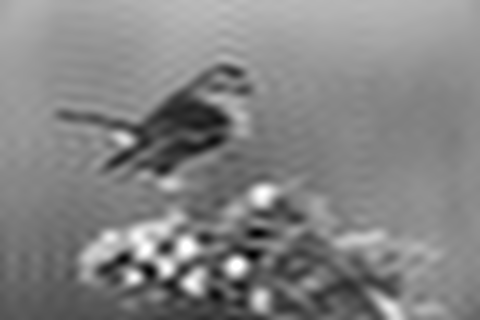

In [13]:
from scipy import fftpack

def get_2D_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

# simply cut out higher frequencies completely.
# this is (loosely) what JPEG does (notice the ringing)
def cutoff(v, co):
    x = v.copy()
    x[co:, :] = 0.0
    x[:, co:] = 0.0
    return x

def dct_filter(t, n):
    # convert to frequencies with DCT
    img_dct = get_2D_dct(t.T)

    img_dct = cutoff(img_dct, n)
    
    img_dct[0,0] *= 0.1
    
    # convert to pixels with inverse DCT
    img_idct = get_2d_idct(img_dct)

    # normalize to 0-255 (pixel value range)
    img_idct -= np.min(img_idct)
    img_idct = np.where(img_idct > 255.0, 255.0, img_idct)
    
    return img_idct
    

# filter out quiet frequencies (frequency weights can be negative)
# uncomment and make it into function like <cutoff>, if you want to try it out
# img_dct = np.where(np.abs(img_dct) < 500.0, 0.0, img_dct)
    
img_idct = dct_filter(tarr, 40)

# show image
Image.fromarray(np.uint8(img_idct))

That looks dope. But what about our glyphs? What parameters would be optimal?

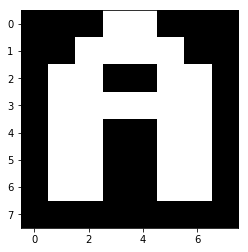

In [14]:
plt.imshow(glyphs[1])

This is the pixel presentation. Now lets figure out how we want to filter it.

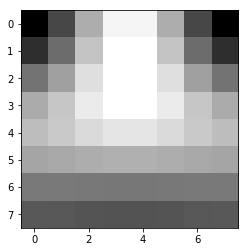

In [15]:
plt.imshow(Image.fromarray(np.uint8(dct_filter(np_glyphs[1], 3))))

Wall time: 3.39 s


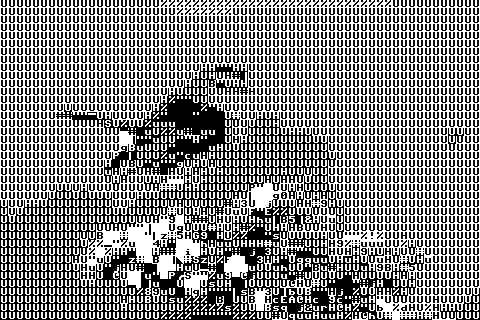

In [16]:
# you can adjust the cutoff value and see what happens, try between 1 to 8 (glyph size)
cval = 4

# do some out of loop optimization
DCT_glyphs = [cutoff(get_2D_dct(i.T), cval) for i in np_glyphs]

def best_fit_DCT(iarr, iglyphs, x, y):
    best_fit = -1
    min_error = float(1e10)

    # find glyph with best fit
    b = iarr[x:x+glyph_x, y:y+glyph_y]
    db = cutoff(get_2D_dct(b.T), cval)
    for i, g in enumerate(iglyphs):
        error = np.sum((g-db)**2)
        if error < min_error:
            best_fit = i
            min_error = error
    return best_fit

    
%time generate(best_fit_DCT, tarr, DCT_glyphs, np_glyphs)

That's it! Congrats for sticking it to the end! Hopefully we learned something about Jupyter, Python, DCT and Least Squares.

...

I do have an idea for an improvement. Changing the cutoff point based on simple [Sobel filtering](https://en.wikipedia.org/wiki/Sobel_operator). There's also [error diffusion](https://en.wikipedia.org/wiki/Error_diffusion) that could be considered.

### Lets try error diffusion

Wall time: 3.55 s


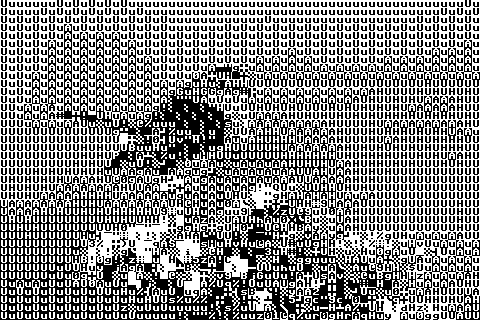

In [17]:
class ErrorDiffusion:
    def __init__(self):
        self.error = 0.0
        self.y = 0
        
diffusion = ErrorDiffusion()
cval = 4
DCT_glyphs = [cutoff(get_2D_dct(i.T), cval) for i in np_glyphs]

def DCT_error(iarr, iglyphs, x, y):
    best_fit = -1
    min_error = float(1e20)

    if diffusion.y != y:
        diffusion.y = y
        diffusion.error = 0.0

    # find glyph with best fit
    b = iarr[x:x+glyph_x, y:y+glyph_y]
    db = cutoff(get_2D_dct(b.T), cval) 
    db -= diffusion.error*1.0
    for i, g in enumerate(iglyphs):
        error = np.sum((g-db)**2)
        if error < min_error:
            best_fit = i
            min_error = error

    if best_fit >= 0:
        a = iglyphs[best_fit]
        b = get_2D_dct(b.T) 
        diffusion.error = a[0,0] - b[0,0]

    return best_fit

%time generate(DCT_error, tarr, DCT_glyphs, np_glyphs)

Simple and effective, yet leaves ugly vertical bars. Maybe there's a better way than this naive approach? Maybe we could try [Floyd-Steinberg dithering](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering)

### Sobel filtering

Simple way to find edges

1.0 0.00949953366403 0.293599243039


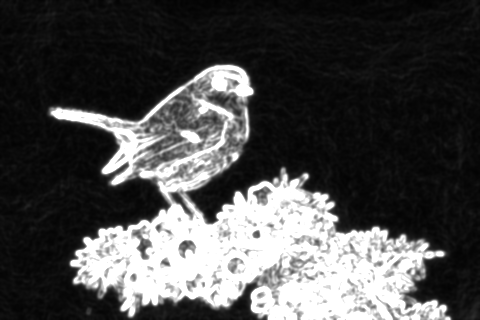

In [18]:
from scipy import ndimage

# Gaussian blur, then find edges
img = ndimage.gaussian_filter(tarr, sigma=1.0)
img = np.abs(ndimage.sobel(img, axis=0)) + np.abs(ndimage.sobel(img, axis=1))
img = ndimage.gaussian_filter(img, sigma=1.0)
img += ndimage.gaussian_filter(img, sigma=4.0)/4
sobel = img

# normalize to 0-1, boost values
sobel /= np.max(sobel)/4
sobel = np.where(sobel>1.0, 1.0, sobel)
print(np.max(sobel), np.min(sobel), np.mean(sobel))

Image.fromarray(np.uint8((sobel*255).T))

Wall time: 5.35 s


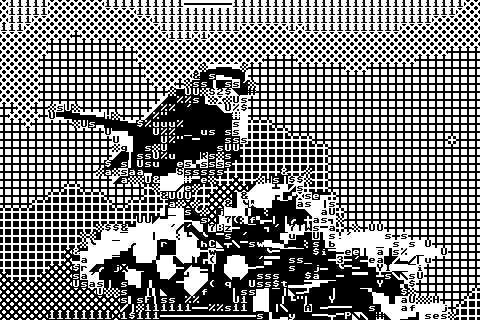

In [21]:
DCT_glyphs = [get_2D_dct(i.T) for i in np_glyphs]

def best_fit_DCT_sobel(iarr, iglyphs, x, y):
    best_fit = -1
    min_error = float(1e10)
    v = 0.0
    
    # calculate sobel weight
    sval = int(1.0 + np.mean(sobel[x:x+glyph_x, y:y+glyph_y])*8.0)
    
    if sval < 2: sval = 2
    if sval > 8: sval = 8

    # find glyph with best fit
    b = iarr[x:x+glyph_x, y:y+glyph_y]
    db = cutoff(get_2D_dct(b.T), sval)
    for i, g in enumerate(iglyphs):
        da = cutoff(g, sval)
        error = np.sum((da-db)**2)*((1.0-v) + random.random()*v)
        if error < min_error:
            best_fit = i
            min_error = error
    return best_fit

    
%time generate(best_fit_DCT_sobel, tarr, DCT_glyphs, np_glyphs)

Looks like it works quite well! 